Программа позволяет моделировать приемную систему 

Исходные данные

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.integrate as integrate

Wavelength = 1.
SizeOfAperture = 5.
NumberOfElements = 100
Distance = 1e-1
len = 1000
NumberOfFunctions = 2**5
min = np.deg2rad(-20)
max = np.deg2rad(20)
width = np.array(np.deg2rad([1.,1.]))
deltarange = np.deg2rad([0.,3.])

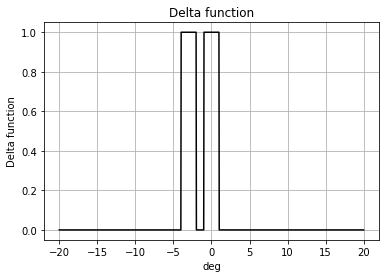

In [106]:
range=np.linspace(min,max,len)
scanrange = range*1.5
#print("Диапазон range = ",np.rad2deg(range))
#print("Диапазон scanrange = ",np.rad2deg(scanrange))

def ddf(x,sig,delta):
    val = np.zeros_like(x)
    val[(-sig<=x+delta) & (x+delta<=sig)] = 1
    return val

def getSignal(range,width,deltarange):
    signal = 0.
    for i in np.arange(0,np.shape(width)[0]):
        signal += ddf(range,width[i],deltarange[i])
    return signal

signal = getSignal(range,width,deltarange)
plt.cla()
plt.grid()
plt.title('Delta function')
plt.xlabel('deg')
plt.ylabel("Delta function")
plt.plot(np.rad2deg(range),signal,color='black')


Угловое разрешение на основе критерия Рэлея

In [107]:
def getRayleighCriterion(Wavelength,SizeOfAperture):
    return Wavelength/SizeOfAperture 

print("Разрешение по Рэлею = ",np.rad2deg(getRayleighCriterion(Wavelength,SizeOfAperture)))

Разрешение по Рэлею =  11.459155902616466


Определяем диаграмму направленности сканирования антенны

C:\Users\PC\AppData\Local\Temp\ipykernel_9064\3521097203.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  f[j] = getDirectionalPattern(0.,x)


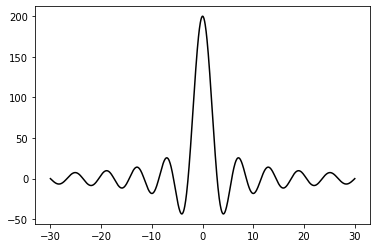

In [108]:
def getDirectionalPattern(alpha,x):
    d = Distance
    N = NumberOfElements
    f = 0.
    f0 = 1.
    k = np.pi*2/Wavelength
    for m in np.arange(-N,N):
        f += f0*np.exp(-1j*k*d*m*(np.sin(alpha) - np.sin(x)))
    return f

f = np.zeros_like(range)
j = -1
for x in scanrange:
    j += 1
    f[j] = getDirectionalPattern(0.,x)
plt.plot(np.rad2deg(scanrange),f,color='black')

Определяем принятый сигнал



In [109]:
def functionReceivedSignal(x,alpha):
    return getDirectionalPattern(alpha,x)*getSignal(x,width,deltarange)

Строим матрицу Адамара

In [110]:
H = scipy.linalg.hadamard(NumberOfFunctions)

Вычисляем функцию Хи и интегрируем уравнение Фредгольма


Диапазон teta =  [-20.         -17.33333333 -14.66666667 -12.          -9.33333333
  -6.66666667  -4.          -1.33333333   1.33333333   4.
   6.66666667   9.33333333  12.          14.66666667  17.33333333
  20.        ]


c:\Users\PC\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\integrate\_quadpack_py.py:463: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)
C:\Users\PC\AppData\Local\Temp\ipykernel_9064\2439790029.py:16: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  U[j],err = integrate.quad(functionReceivedSignal,min,max,args=(alpha,))


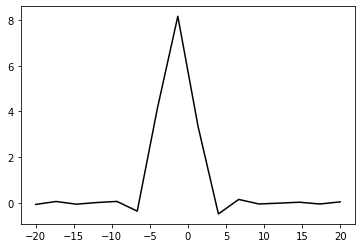

In [111]:
def functionHi(x,alpha,m,j):
    return getDirectionalPattern(alpha,x)*H[m,j]

sz = NumberOfFunctions
Hi = np.zeros((sz,sz))
U = np.zeros(sz)

j = -1
min = range.min()
max = range.max()

teta = np.linspace(min,max,sz)
print("Диапазон teta = ",np.rad2deg(teta))
for alpha in teta:
    j += 1
    U[j],err = integrate.quad(functionReceivedSignal,min,max,args=(alpha,)) 
    for m in np.arange(0,sz):  
        Hi[m,j],err = integrate.quad(functionHi,min,max,args=(alpha,m,j,)) 

plt.plot(np.rad2deg(teta),U,color='black')

Строим СЛАУ

U = H*B

B = H^-1*U

In [112]:
B = np.linalg.inv(Hi)@U

Вычисляем распределение интенсивности - сверхразрешение

I = H*B

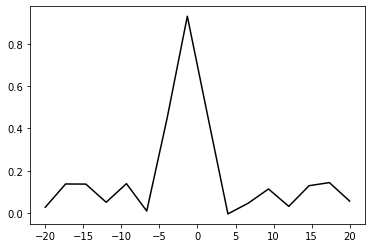

In [113]:
I = H@B
plt.plot(np.rad2deg(teta),I,color='black')